In [1]:
# Email Spam Detection with Transformers from Scratch
# ======================================
# This notebook builds a spam detection model using distilbert
# Author: Showkot Hossain
# Course: Neural Networks
# Semester: Spring 2025
# Instructor: Prof. Adam Czajka
# University of Notre Dame, Notre Dame, IN 46556

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is i

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# For transformers
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import Dataset, DatasetDict

# Download and extract the dataset
!wget -nc https://github.com/MWiechmann/enron_spam_data/raw/master/enron_spam_data.zip
!unzip -o enron_spam_data.zip

--2025-05-01 00:01:30--  https://github.com/MWiechmann/enron_spam_data/raw/master/enron_spam_data.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MWiechmann/enron_spam_data/master/enron_spam_data.zip [following]
--2025-05-01 00:01:31--  https://raw.githubusercontent.com/MWiechmann/enron_spam_data/master/enron_spam_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15642124 (15M) [application/zip]
Saving to: ‘enron_spam_data.zip’

enron_spam_data.zip 100%[===================>]  14.92M  --.-KB/s    in 0.1s    

2025-05-01 00:01:31 (140 MB/s) - ‘enron_spam_data.zip’ saved [15642124/156421

In [4]:
# Load the CSV file
df = pd.read_csv('enron_spam_data.csv')

In [5]:
# Display dataset information
print(f"Total emails: {len(df)}")
print(f"Column names: {df.columns.tolist()}")

# Let's print the first few rows to understand the data structure
print("\nFirst few rows of the dataset:")
print(df.head(2))

# Check for label column and convert to binary
if 'Spam/Ham' in df.columns:
    # Convert Spam/Ham labels to binary (1 for spam, 0 for ham)
    df['label'] = df['Spam/Ham'].apply(lambda x: 1 if x.lower() == 'spam' else 0)
else:
    # Look for other potential label columns
    potential_label_cols = [col for col in df.columns if any(keyword in col.lower() for keyword in ['spam', 'ham', 'label', 'class'])]
    if potential_label_cols:
        print(f"Potential label columns found: {potential_label_cols}")
        # Use the first potential column
        df['label'] = df[potential_label_cols[0]].apply(lambda x: 1 if str(x).lower() == 'spam' else 0)
    else:
        raise ValueError("Couldn't identify label column in the dataset")

# Find the appropriate text column - in the Enron dataset it's 'Message'
if 'Message' in df.columns:
    df['text'] = df['Message']
else:
    # Try to find text column
    text_cols = [col for col in df.columns if any(keyword in col.lower() for keyword in ['text', 'message', 'email', 'content', 'body'])]
    if text_cols:
        print(f"Potential text columns found: {text_cols}")
        df['text'] = df[text_cols[0]]
    else:
        # If no obvious text column, use the column with the longest average string length
        string_cols = df.select_dtypes(include=['object']).columns
        avg_lengths = {col: df[col].astype(str).str.len().mean() for col in string_cols}
        text_col = max(avg_lengths, key=avg_lengths.get)
        print(f"Using '{text_col}' as text column based on content length")
        df['text'] = df[text_col]

# Print dataset distribution
print(f"Spam emails: {sum(df['label'])}")
print(f"Ham emails: {len(df) - sum(df['label'])}")
print(f"Spam ratio: {sum(df['label'])/len(df):.2f}")

# Check if text column was correctly assigned
print("\nSample text column entries:")
print(df['text'].head(2).tolist())

# Display sample emails
print("\nSample SPAM email:")
spam_sample = df[df['label'] == 1]['text'].iloc[0]
print(spam_sample[:500] + "..." if len(str(spam_sample)) > 500 else spam_sample)

print("\nSample HAM email:")
ham_sample = df[df['label'] == 0]['text'].iloc[1]
print(ham_sample[:500] + "..." if len(str(ham_sample)) > 500 else ham_sample)

Total emails: 33716
Column names: ['Message ID', 'Subject', 'Message', 'Spam/Ham', 'Date']

First few rows of the dataset:
   Message ID                       Subject  \
0           0  christmas tree farm pictures   
1           1      vastar resources , inc .   

                                             Message Spam/Ham        Date  
0                                                NaN      ham  1999-12-10  
1  gary , production from the high island larger ...      ham  1999-12-13  
Spam emails: 17171
Ham emails: 16545
Spam ratio: 0.51

Sample text column entries:
[nan, 'gary , production from the high island larger block a - 1 # 2 commenced on\nsaturday at 2 : 00 p . m . at about 6 , 500 gross . carlos expects between 9 , 500 and\n10 , 000 gross for tomorrow . vastar owns 68 % of the gross production .\ngeorge x 3 - 6992\n- - - - - - - - - - - - - - - - - - - - - - forwarded by george weissman / hou / ect on 12 / 13 / 99 10 : 16\nam - - - - - - - - - - - - - - - - - - - - - - - -

<ipython-input-6-bd05e23d257b>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['email_length'] = df['text'].apply(len)



Average email length: 989.36 characters
Max email length: 4247 characters
Min email length: 1 characters


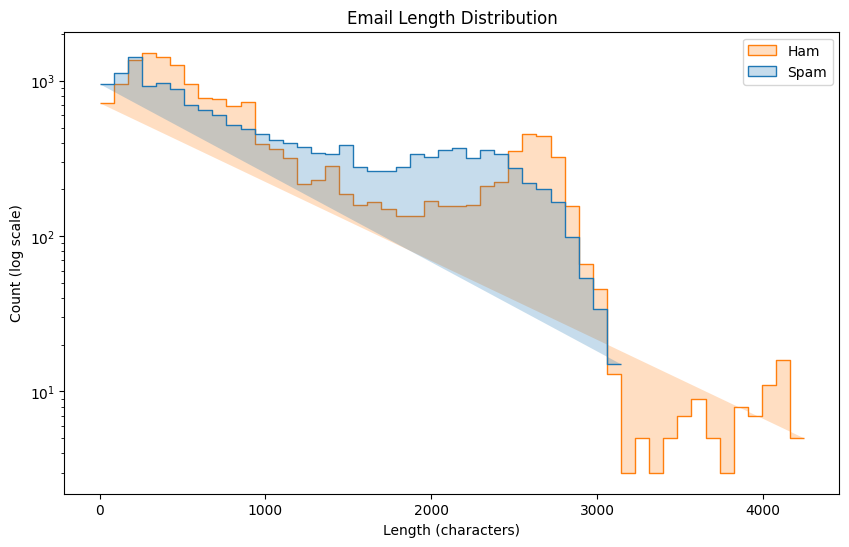

In [6]:
# Preprocess emails
def preprocess_email(text):
    if pd.isna(text):
        return ""

    # Convert to string if not already
    text = str(text)

    # Truncate long emails to 512 tokens
    words = text.split()
    if len(words) > 512:
        text = ' '.join(words[:512])

    return text

# Apply preprocessing
df['text'] = df['text'].apply(preprocess_email)

# Remove any rows with empty text
df = df[df['text'].str.strip() != ""]

# Check email lengths after preprocessing
df['email_length'] = df['text'].apply(len)
print(f"\nAverage email length: {df['email_length'].mean():.2f} characters")
print(f"Max email length: {df['email_length'].max()} characters")
print(f"Min email length: {df['email_length'].min()} characters")

# Plot length distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='email_length', hue='label', bins=50,
             element="step", common_norm=False,
             log_scale=(False, True))
plt.title('Email Length Distribution')
plt.xlabel('Length (characters)')
plt.ylabel('Count (log scale)')
plt.legend(labels=['Ham', 'Spam'])
plt.show()

In [7]:
# Split data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42, stratify=train_df['label'])

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# Convert to Hugging Face datasets
def df_to_dataset(df):
    # Just use text and label columns
    return Dataset.from_pandas(df[['text', 'label']])

datasets = DatasetDict({
    'train': df_to_dataset(train_df),
    'val': df_to_dataset(val_df),
    'test': df_to_dataset(test_df)
})

Training set size: 24008
Validation set size: 2668
Test set size: 6669


In [8]:
# Initialize tokenizer and model
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

# Tokenize datasets
tokenized_datasets = datasets.map(tokenize_function, batched=True)

# Prepare for training
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/24008 [00:00<?, ? examples/s]

Map:   0%|          | 0/2668 [00:00<?, ? examples/s]

Map:   0%|          | 0/6669 [00:00<?, ? examples/s]

In [9]:
# Model initialization
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./spam_detection_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    # Disable wandb reporting
    report_to="none",
    # Enable fp16 if using GPU
    fp16=True,
)

# Custom accuracy metric calculation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": (predictions == labels).mean()}

In [11]:
# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["val"],
    compute_metrics=compute_metrics,
)

In [12]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.038600,0.032586,0.991754
2,0.010200,0.039560,0.992504
3,0.001000,0.038794,0.994003


TrainOutput(global_step=9003, training_loss=0.028429141153723057, metrics={'train_runtime': 1092.0033, 'train_samples_per_second': 65.956, 'train_steps_per_second': 8.244, 'total_flos': 9540831920799744.0, 'train_loss': 0.028429141153723057, 'epoch': 3.0})

In [13]:
# Evaluate on test set
results = trainer.evaluate(tokenized_datasets["test"])
print(f"Test Accuracy: {results['eval_accuracy']:.4f}")

Test Accuracy: 0.9952



Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3299
           1       1.00      1.00      1.00      3370

    accuracy                           1.00      6669
   macro avg       1.00      1.00      1.00      6669
weighted avg       1.00      1.00      1.00      6669



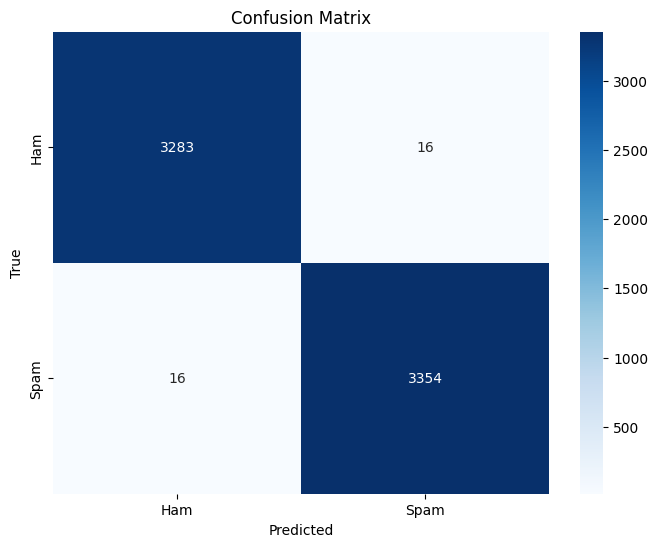

In [14]:
# Make predictions on test set for detailed analysis
predictions = trainer.predict(tokenized_datasets["test"])
preds = np.argmax(predictions.predictions, axis=-1)

# Print classification report
print("\nClassification Report:")
print(classification_report(test_df['label'], preds))

# Create confusion matrix
cm = confusion_matrix(test_df['label'], preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# Save the model
model_save_path = "./spam_detection_final_model"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ./spam_detection_final_model


In [16]:
# Function to predict on new emails
def predict_spam(emails, model_path="./spam_detection_final_model"):
    # Load saved model and tokenizer
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    # Process emails
    inputs = tokenizer(emails, padding=True, truncation=True, max_length=512, return_tensors="pt")

    # Make predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Get predicted class (0=ham, 1=spam)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    pred_labels = torch.argmax(predictions, dim=-1).numpy()

    # Get confidence scores
    confidence = predictions.numpy().max(axis=1)

    results = []
    for i, email in enumerate(emails):
        label = "SPAM" if pred_labels[i] == 1 else "HAM"
        results.append({
            "email": email[:100] + "..." if len(email) > 100 else email,
            "prediction": label,
            "confidence": f"{confidence[i]:.4f}"
        })

    return pd.DataFrame(results)

In [17]:
# Test with example emails
example_emails = [
    "Hey Showkot, how are you? Please complete the assigned task by the deadline. Have fun!",
    "hello world!",
    "Hi, My Name is Sarika (Business Consultant). I found your web contact email from internet. I would like to discuss a business opportunity with you. We are an India based CMM I Level 3 Website Development Company with a primary focus on Website.",
    "CONGRATULATIONS! You've WON $10,000,000.00 in our lottery! Send your bank details now to claim your prize!",
    "Please find attached the quarterly report for your review. Let me know if you have any questions.",
    "URGENT: Your account has been compromised. Click here immediately to verify your details and secure your account."
]

prediction_df = predict_spam(example_emails)
print("\nPredictions on new emails:")
print(prediction_df)


Predictions on new emails:
                                               email prediction confidence
0  Hey Showkot, how are you? Please complete the ...        HAM     0.9999
1                                       hello world!       SPAM     0.9956
2  Hi, My Name is Sarika (Business Consultant). I...       SPAM     1.0000
3  CONGRATULATIONS! You've WON $10,000,000.00 in ...       SPAM     1.0000
4  Please find attached the quarterly report for ...        HAM     0.9999
5  URGENT: Your account has been compromised. Cli...       SPAM     1.0000


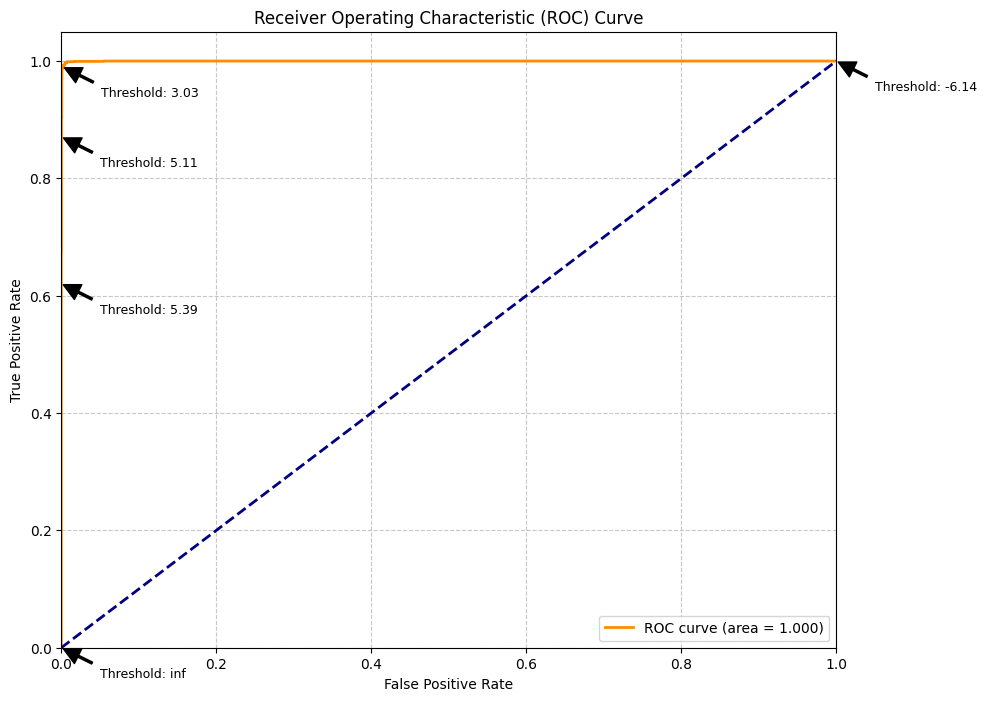

In [18]:
# ROC Curve Visualization
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# Get probabilities for the positive class (Spam)
y_scores = predictions.predictions[:, 1]
y_true = test_df['label']

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Add some threshold annotations
threshold_indices = np.array([len(thresholds) - 1,
                             len(thresholds) // 2,
                             len(thresholds) // 4,
                             len(thresholds) // 10,
                             0])

for i in threshold_indices:
    if i < len(thresholds):
        threshold = thresholds[i]
        plt.annotate(f'Threshold: {threshold:.2f}',
                    xy=(fpr[i], tpr[i]),
                    xytext=(fpr[i]+0.05, tpr[i]-0.05),
                    arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
                    fontsize=9,
                    backgroundcolor='white')

plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

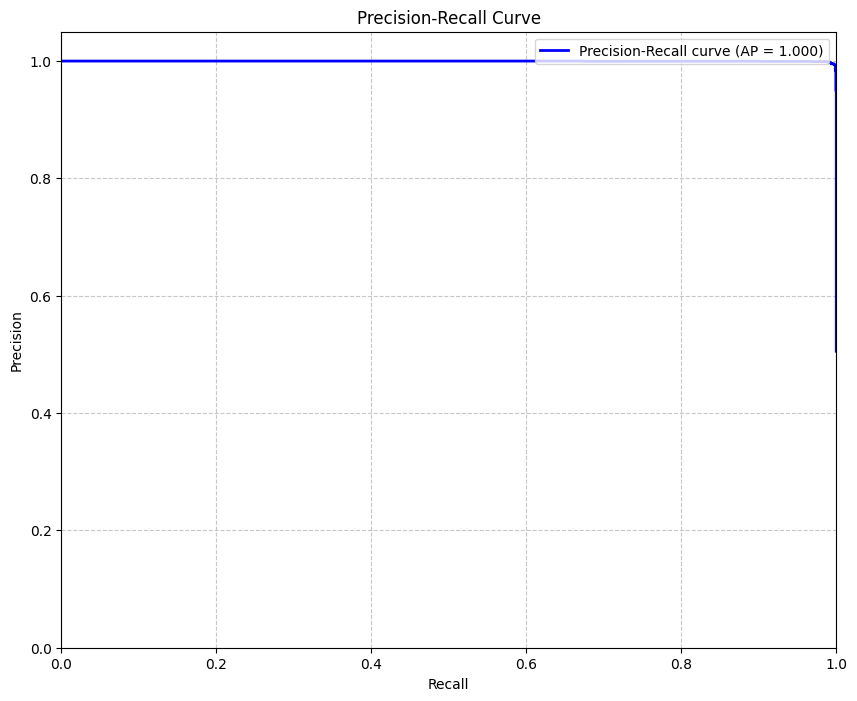

In [19]:
# Calculate and plot Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_true, y_scores)
average_precision = average_precision_score(y_true, y_scores)

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='blue', lw=2,
         label=f'Precision-Recall curve (AP = {average_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.grid(True, linestyle='--', alpha=0.7)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

<ipython-input-20-1b8a14994fb2>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette=['blue', 'red'])
<ipython-input-20-1b8a14994fb2>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Value', data=metrics, palette='viridis')


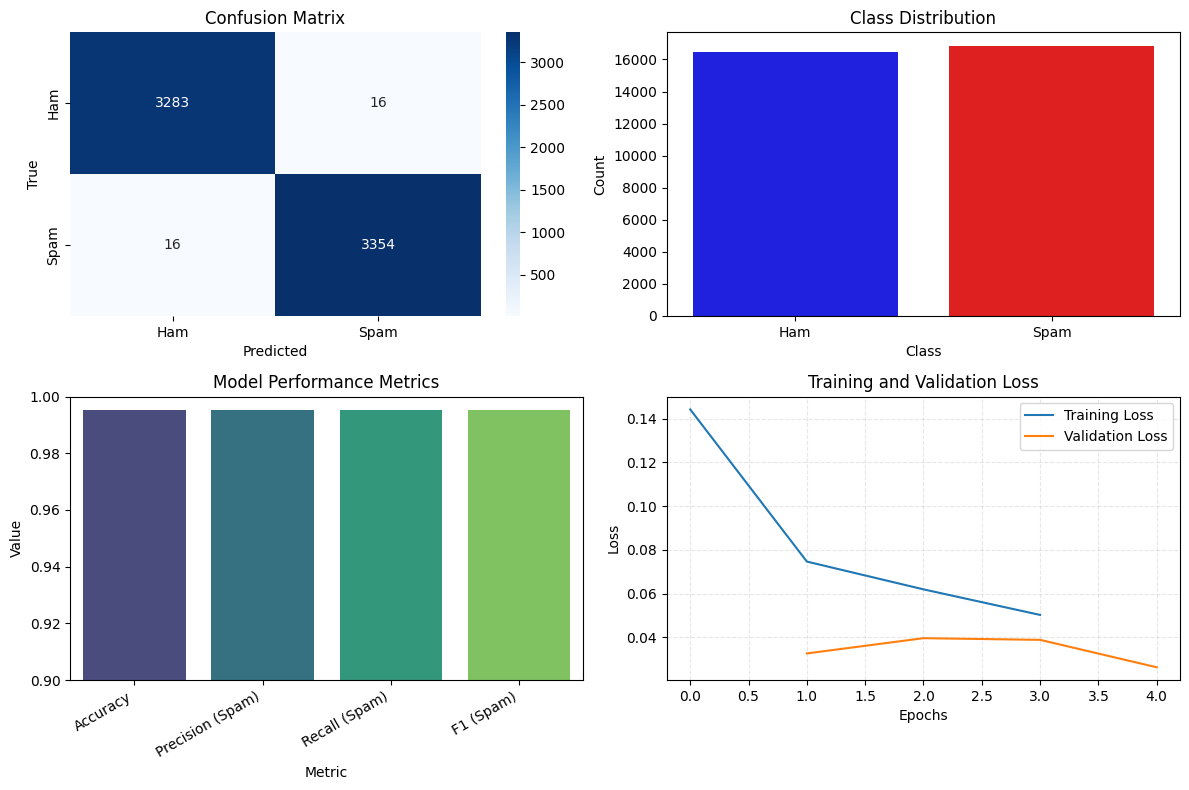


====== Spam Detection Model Summary ======
Model: DistilBERT (fine-tuned)
Dataset: Enron Spam/Ham
Training samples: 24008
Test accuracy: 0.9952
Precision (Spam): 0.9953
Recall (Spam): 0.9953
F1 Score (Spam): 0.9953
Misclassification rate: 0.0048


In [20]:
# Final Visualizations
# Create a summary visualization showing model performance
plt.figure(figsize=(12, 8))

# Create a 2x2 grid for our summary visualizations
plt.subplot(2, 2, 1)
# Plot confusion matrix again
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Ham', 'Spam'],
            yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Plot class distribution
plt.subplot(2, 2, 2)
sns.countplot(x='label', data=df, palette=['blue', 'red'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.xticks([0, 1], ['Ham', 'Spam'])
plt.ylabel('Count')

# Plot accuracy metrics
plt.subplot(2, 2, 3)
metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision (Spam)', 'Recall (Spam)', 'F1 (Spam)'],
    'Value': [
        accuracy_score(test_df['label'], preds),
        classification_report(test_df['label'], preds, output_dict=True)['1']['precision'],
        classification_report(test_df['label'], preds, output_dict=True)['1']['recall'],
        classification_report(test_df['label'], preds, output_dict=True)['1']['f1-score']
    ]
})
sns.barplot(x='Metric', y='Value', data=metrics, palette='viridis')
plt.title('Model Performance Metrics')
plt.ylim(0.9, 1.0)  # Adjust as needed based on your results
plt.xticks(rotation=30, ha='right')

# Plot training curves
plt.subplot(2, 2, 4)
train_losses = [log["loss"] for log in trainer.state.log_history if "loss" in log and "eval_loss" not in log]
eval_losses = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]
epochs = list(range(1, len(eval_losses) + 1))
plt.plot(train_losses[:len(epochs)], label='Training Loss')
plt.plot(epochs, eval_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('spam_detection_summary.png')
plt.show()

print("\n====== Spam Detection Model Summary ======")
print(f"Model: DistilBERT (fine-tuned)")
print(f"Dataset: Enron Spam/Ham")
print(f"Training samples: {len(train_df)}")
print(f"Test accuracy: {results['eval_accuracy']:.4f}")
print(f"Precision (Spam): {classification_report(test_df['label'], preds, output_dict=True)['1']['precision']:.4f}")
print(f"Recall (Spam): {classification_report(test_df['label'], preds, output_dict=True)['1']['recall']:.4f}")
print(f"F1 Score (Spam): {classification_report(test_df['label'], preds, output_dict=True)['1']['f1-score']:.4f}")
print(f"Misclassification rate: {(1 - results['eval_accuracy']):.4f}")
print("=======================================")



# Creating t-SNE Visualization of Email Embeddings
Creating balanced samples for visualization...
Generating t-SNE visualization (this may take a moment)...


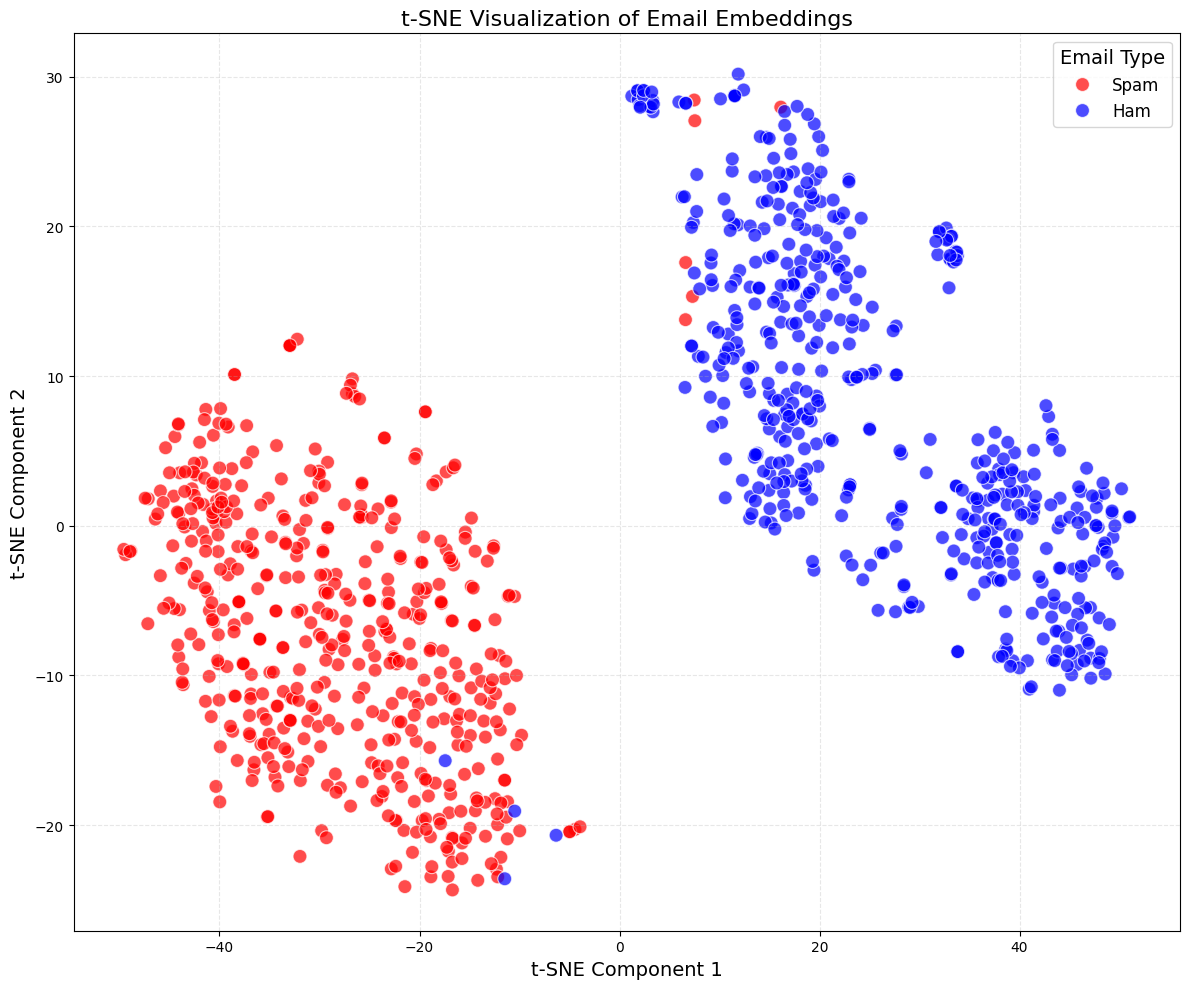

In [29]:
# t-SNE Visualization
from sklearn.manifold import TSNE

# Creating helper functions for later use in t-SNE visualization
def get_embeddings(model, tokenizer, texts, max_length=128):
    """Extract embeddings from the model"""
    # Determine the device the model is on
    device = next(model.parameters()).device

    # Process inputs and move to the correct device
    inputs = tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        # Get the last hidden state from the model
        outputs = model.distilbert(**inputs)
        # Use CLS token embedding as the sentence embedding
        embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    return embeddings

def visualize_tsne(model, tokenizer, texts, labels, perplexity=30):
    """Visualize text embeddings using t-SNE"""
    # Get embeddings
    embeddings = get_embeddings(model, tokenizer, texts)

    # Adjust perplexity for small datasets
    perplexity = min(perplexity, len(texts) - 1)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    tsne_result = tsne.fit_transform(embeddings)

    # Create a dataframe for plotting
    tsne_df = pd.DataFrame({
        'x': tsne_result[:, 0],
        'y': tsne_result[:, 1],
        'class': ['Ham' if label == 0 else 'Spam' for label in labels]
    })

    # Plot t-SNE results
    plt.figure(figsize=(12, 10))
    scatter = sns.scatterplot(
        data=tsne_df, x='x', y='y', hue='class',
        palette={'Ham': 'blue', 'Spam': 'red'},
        s=100, alpha=0.7
    )
    plt.title('t-SNE Visualization of Email Embeddings', fontsize=16)
    plt.xlabel('t-SNE Component 1', fontsize=14)
    plt.ylabel('t-SNE Component 2', fontsize=14)

    # Add legend with descriptive title
    plt.legend(title='Email Type', fontsize=12, title_fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

    return tsne_df

# t-SNE Visualization
print("\n\n# Creating t-SNE Visualization of Email Embeddings")
print("Creating balanced samples for visualization...")

# Sample emails for t-SNE visualization (limit sample size for performance)
np.random.seed(42)
sample_size = 500

# Create balanced samples
spam_indices = test_df[test_df['label'] == 1].index.tolist()
ham_indices = test_df[test_df['label'] == 0].index.tolist()

# Randomly sample
sampled_spam_indices = np.random.choice(spam_indices, min(sample_size, len(spam_indices)), replace=False)
sampled_ham_indices = np.random.choice(ham_indices, min(sample_size, len(ham_indices)), replace=False)

# Combine samples
sampled_indices = np.concatenate([sampled_spam_indices, sampled_ham_indices])
sampled_df = test_df.loc[sampled_indices]

# Visualize with t-SNE
print("Generating t-SNE visualization (this may take a moment)...")
tsne_df = visualize_tsne(model, tokenizer, sampled_df['text'].tolist(), sampled_df['label'].tolist())